In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import glob

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [ ]:
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [ ]:
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 

In [ ]:
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score

In [ ]:
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

In [ ]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 

In [ ]:
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

In [ ]:
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

In [ ]:
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

In [ ]:
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height

In [ ]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
    #len(labels)
		for i in range(2,9):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

In [ ]:
from PIL import Image, ImageDraw as D


In [ ]:
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
  data = pyplot.imread(filename)
  im=Image.open(filename)  #*************************************
  #im=Image.fromarray(im)
  #draw = ImageDraw.Draw(data)
	# plot the image
  pyplot.imshow(data)
	# get the context for drawing boxes
  ax = pyplot.gca()
	# plot each box
  for i in range(len(v_boxes)):
   box = v_boxes[i]
   # get coordinates
   y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
	 # calculate width and height of the box
   width, height = x2 - x1, y2 - y1
   # create the shape
   rect = Rectangle((x1, y1), width, height, fill=False, color='white')
   draw=D.Draw(im)                                           #************************************
   draw.rectangle([(x1, y1), (x2, y2)], outline="red") #***********************************
   #im = cv2.putText(np.array(im), 'Fedex', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
   #draw.Rectangle((x1, y1), width, height, fill=False, color='white')
   # draw the box
   ax.add_patch(rect)
   # draw text and score in top left corner
   label = "%s (%.3f)" % (v_labels[i], v_scores[i])
   pyplot.text(x1, y1, label, color='white')
   # show the plot
  # pyplot.show()
  return im #************************************************

**Converting stored frames to boxed images and further to a video of boxed images**

In [ ]:
def predict_enbox_images(photo_filename):
  # load yolov3 model
  model = load_model('/content/drive/MyDrive/model.h5')
  # define the expected input shape for the model
  input_w, input_h = 416, 416
  # define our new photo
  #photo_filename = 'zebra.jpeg'
  # load and prepare image
  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
  # make prediction
  yhat = model.predict(image)
  # summarize the shape of the list of arrays
  print([a.shape for a in yhat])
  # define the anchors
  anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
  # define the probability threshold for detected objects
  class_threshold = 0.6
  boxes = list()
  for i in range(len(yhat)):
	  # decode the output of the network
	  boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
  # suppress non-maximal boxes
  do_nms(boxes, 0.5)
  # define the labels
  labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	  "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	  "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	  "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	  "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	  "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	  "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	  "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	  "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	  "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
  # summarize what we found
  for i in range(len(v_boxes)):
	  print(v_labels[i], v_scores[i])
  # draw what we found
  return draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [ ]:
import os, os.path,shutil

In [ ]:
name_dir = "vdeo_clip_5"
num_file = len([name for name in os.listdir('/content/drive/MyDrive/A2PartC_vdeo_frames/'+name_dir)])
print(num_file)

596


In [ ]:
## Convert given Frames to Boxed Frames
img_array = []
for i in range(0,num_file):
  print(i)
  name = "img"+str(i)+".jpeg"
  img_array.append(predict_enbox_images("/content/drive/MyDrive/A2PartC_vdeo_frames/"+name_dir+"/"+name))
  cv2.imwrite(os.path.join("/content/drive/MyDrive/A2PartC_vdeo_frames/Boxed_images/"+name_dir+"/" , name), cv2.cvtColor(np.array(img_array[i]), cv2.COLOR_RGB2BGR))
  cv2.waitKey(0)

0
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
car 96.17054462432861
motorbike 83.2007884979248
motorbike 96.9059407711029
motorbike 88.20614814758301
motorbike 76.71406269073486
1
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
car 83.94032120704651
motorbike 92.29328036308289
motorbike 93.67321729660034
motorbike 60.301774740219116
2
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
car 92.96457171440125
motorbike 96.75044417381287
motorbike 87.32213973999023
motorbike 72.3986029624939
motorbike 75.2187728881836
3
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
car 96.29591107368469
motorbike 87.50613927841187
motorbike 86.61468029022217
motorbike 86.678147315979
motorbike 79.30946946144104
4
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
car 95.86321115493774
motorbike 90.59332609176636
motorbike 97.31786847114563
5
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
car 95.67563533782959
motorbike 91.1950409412384
motorbike 96.95661664009094


In [ ]:
img_array[0].size

(1280, 720)

In [ ]:
# cv2.imread(img_array)

## **Frames to Video**

In [ ]:
## Convert stored Frames to Video
out = cv2.VideoWriter('vdeo_clip_5_boxed.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, (1280, 720))
 
for i in range(len(img_array)):
    out.write(cv2.cvtColor(np.array(img_array[i]), cv2.COLOR_RGB2BGR))
    print(i)
out.release()


In [ ]:
## Store video to appropriate drive location
shutil.copy('vdeo_clip_5_boxed.mp4', '/content/drive/MyDrive/A2PartC_vdeo_frames/Boxed_images')

'/content/drive/MyDrive/A2PartC_vdeo_frames/Boxed_images/vdeo_clip_4_boxed.mp4'

In [ ]:
# for i in range(len(img_array)):
#   print(np.array(img_array[i]))
#   break
plt.figure(figsize=(20, 10))
for i in range(0,9):
  img=plt.subplot(3, 3,i+1)
  #img.set_title(classes[i])
  plt.imshow(img_array[i*50],cmap='gray')

In [ ]:
# np.array(img_array[0])

## **For Converting Video to Frames and storing in drive Path as specified**

In [ ]:
videoImages=[]
cap= cv2.VideoCapture('/content/drive/MyDrive/A2PartC_vdeo_frames/vdeo_clip_6.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    # cv2.imwrite('kang'+str(i)+'.jpg',frame)
    videoImages.append(frame)
    #print(frame)
    i+=1
 
cap.release()
cv2.destroyAllWindows()

In [ ]:
np.array(videoImages).shape

(805, 720, 1280, 3)

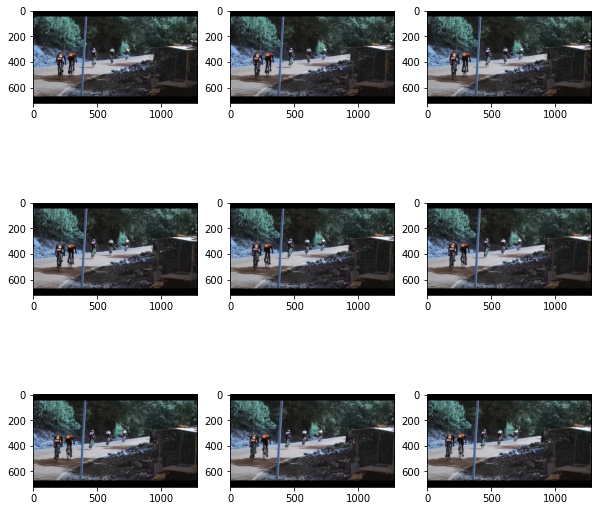

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(0,9):
  img=plt.subplot(3, 3,i+1)
  #img.set_title(classes[i])
  plt.imshow(videoImages[i],cmap='gray')


#  Upload frames to Drive

In [ ]:
for i in range(0,len(videoImages)):
  name="img"+str(i)+".jpeg"
  cv2.imwrite(os.path.join("/content/drive/MyDrive/A2PartC_vdeo_frames/vdeo_clip_6" , name), videoImages[i])
  cv2.waitKey(0)

In [ ]:
# len(videoImages)

805

In [ ]:
# !ls /content/drive/MyDrive/A2PartC_vdeo_frames/vdeo_clip_6


img0.jpeg    img221.jpeg  img343.jpeg  img465.jpeg  img587.jpeg  img708.jpeg
img100.jpeg  img222.jpeg  img344.jpeg  img466.jpeg  img588.jpeg  img709.jpeg
img101.jpeg  img223.jpeg  img345.jpeg  img467.jpeg  img589.jpeg  img70.jpeg
img102.jpeg  img224.jpeg  img346.jpeg  img468.jpeg  img58.jpeg	 img710.jpeg
img103.jpeg  img225.jpeg  img347.jpeg  img469.jpeg  img590.jpeg  img711.jpeg
img104.jpeg  img226.jpeg  img348.jpeg  img46.jpeg   img591.jpeg  img712.jpeg
img105.jpeg  img227.jpeg  img349.jpeg  img470.jpeg  img592.jpeg  img713.jpeg
img106.jpeg  img228.jpeg  img34.jpeg   img471.jpeg  img593.jpeg  img714.jpeg
img107.jpeg  img229.jpeg  img350.jpeg  img472.jpeg  img594.jpeg  img715.jpeg
img108.jpeg  img22.jpeg   img351.jpeg  img473.jpeg  img595.jpeg  img716.jpeg
img109.jpeg  img230.jpeg  img352.jpeg  img474.jpeg  img596.jpeg  img717.jpeg
img10.jpeg   img231.jpeg  img353.jpeg  img475.jpeg  img597.jpeg  img718.jpeg
img110.jpeg  img232.jpeg  img354.jpeg  img476.jpeg  img598.jpeg  img719.jpeg
i